In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mspec as ms # import our own class to make a raman spectrum

%matplotlib inline

plt.style.use(['default', 'seaborn'])

## 1. Δημιουργία συνθετικών δεδομένων

Η κλάση ``Spectrum`` σας επιτρέπει να κατασκευάσετε ένα φάσμα Raman σε ένα συγκεκριμένο εύρος μηκών κύματος. Το φάσμα αυτό μπορεί να περιέχει **έως** και τρεις ξεχωριστές συνιστώσες (components) κάθε μία με το δικό της μοναδικό φάσμα. Μπορείτε επίσης να καθορίσετε τον αριθμό των κορυφών που θα έχει το κάθε φάσμα απο τις συνιστώσες σε διάφορα μήκη κύματος. 

Η αρχικοποίηση ενός φάσματος βασίζεται στις εξής παραμέτρους:

1. Γραμμικό εύρος μηκών κύματος (1D πίνακας numpy).

2. Αριθμός (ακέραιος) συνιστωσών που υπάρχουν στο φάσμα.

3. Λίστα με τους αριθμούς (ακέραιοι) γκαουσιανών κορυφών που περιέχει το φάσμα κάθε συνιστώσας.

4. Λίστα με τις συγκεντρώσεις (πραγματικοί αριθμοί) της κάθε συνιστώσας στο τελικό φάσμα.



Αρχικά ας ορίσουμε το εύρος μηκών κύματος. Επιλέγουμε μήκη κύματος που αντιστοιχούν στο κόκκινο χρώμα $(\sim 620 - 780\,\text{nm})$. Επιλέγουμε να πάρουμε συνολικά 1024 τιμές μηκών κύματος σε αυτό το εύρος που ισαπέχουν μεταξύ τους.

In [2]:
wavelengths = np.linspace(650, 783, 1024)

Στη συνέχεια θα ορίσουμε τα χαρακτηριστικά που θέλουμε να έχει το φάσμα μας. Επιθυμούμε να κατασκευάσουμε τρία διαφορετικά φάσματα που αντιστοιχούν σε τρεις διαφορετικά συστατικά (συνιστώσες) και στη συνέχεια να τα αναμίξουμε με συγκεκριμένες αναλογίες ώστε να πάρουμε ένα τελικό φάσμα του μίγματος.

In [3]:
config = ms.SpectrumConfig(wavelengths, n_components=3, concentration=[0.5,0.3,0.2])

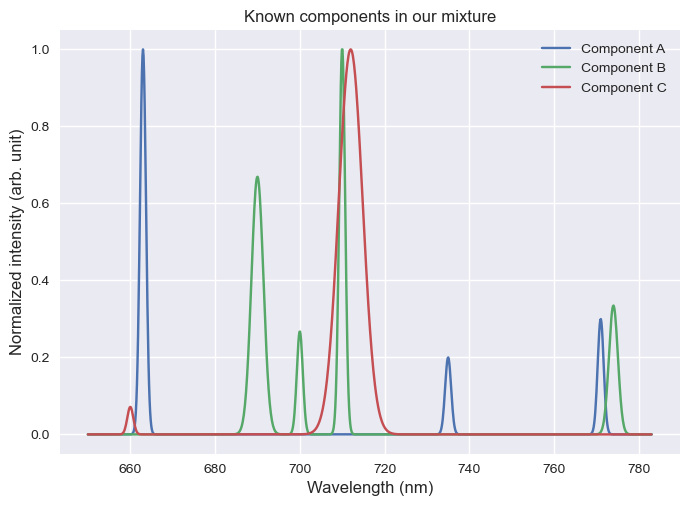

In [4]:
mixed_spectrum = ms.Spectrum(config)
mixed_spectrum.plot_components()

Έχοντας τα φάσματα των τριών συνιστωσών και τις αναλογίες βάσει των οποίων θα αναμιχθούν, κατασκευάζουμε το τελικό φάσμα του μίγματος.

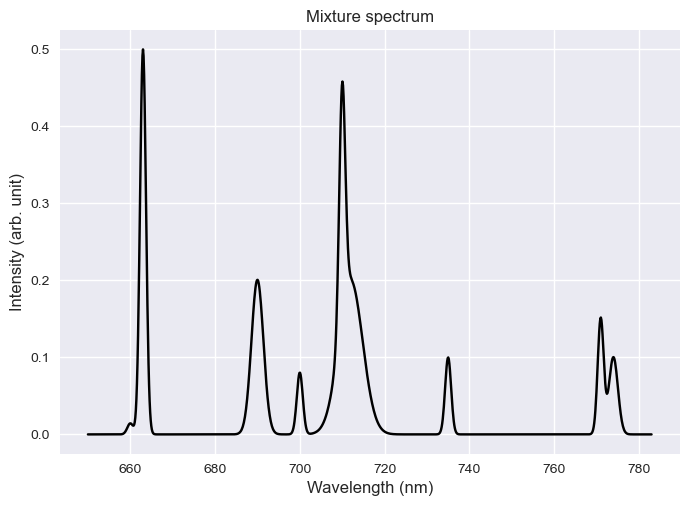

In [5]:
mixed_spectrum.plot_spectrum()

Για να κάνουμε το φάσμα πιο ρεαλιστικό και πιο κοντά σε αυτό που θα παίρναμε αν κάναμε φασματοσκοπικές μετρήσεις σε κάποιο πείραμα, θα προσθέσουμε τυχαίο θόρυβο που μπορεί να οφείλειται στα όργανα καταγραφής, ένα υπόβαθρο, καθώς και τυχαίες αιχμές λόγω κοσμικών ακτίνων που καταγράφονται από την κάμερά μας.

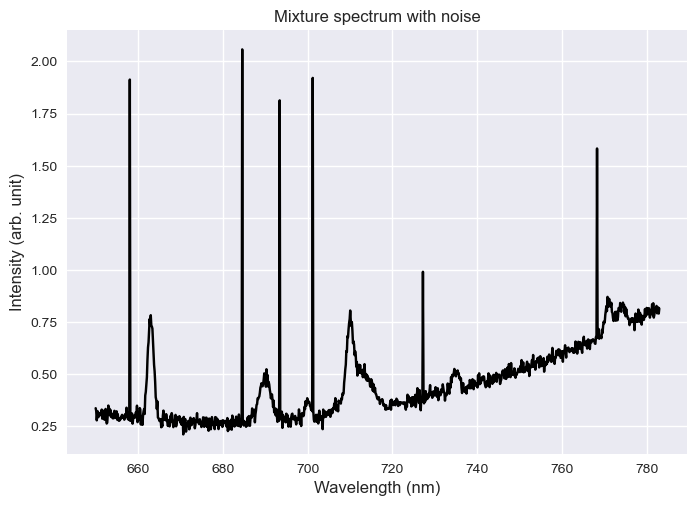

In [6]:
mixed_spectrum.plot_spectrum(add_noise=True, add_baseline=True, add_spikes=True)

## 2. Εγγραφή δεδομένων σε αρχείο

In [7]:
import csv
import pandas as pd

Αρχικά θα εξάγουμε το συνθετικό φάσμα Raman που δημιουργήσαμε προηγουμένως σε ένα αρχείο csv.

In [8]:
intensity = mixed_spectrum.to_array(add_noise=True, add_baseline=True, add_spikes=True, verbose=True)
header = ["Wavelength (nm)", "Intensity (arb. unit)"]
csv_data = [header] # list that will hold the header + the data

for i, j in zip(wavelengths, intensity):
    data_row = [i, j]
    csv_data.append(data_row)
    
with open("synthetic_spectrum.csv", "w") as out_file:
    writer = csv.writer(out_file)    
    writer.writerows(csv_data)   

Random noise added to spectrum: Done
Baseline added to spectrum: Done
Cosmic ray spikes added to spectrum: Done (6 spikes)


Στη συνέχεια θα διαβάσουμε αυτό το αρχείο και θα το "χαλάσουμε" αντικαθιστώντας εγγραφές σε τυχαίες θέσεις με κάποιες προβληματικές τιμές (π.χ. κενές εγγραφές, συμβολοσειρές κτλ).

In [9]:
data = pd.read_csv("synthetic_spectrum.csv", dtype=object, na_filter=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Wavelength (nm)        1024 non-null   object
 1   Intensity (arb. unit)  1024 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB


In [10]:
n_bad_values = 28 # number of bad values to be added
idxs = [] # indeces that will contain bad values

for _ in range(n_bad_values + 1):
    idx = np.random.randint(0, len(wavelengths))
    if idx in idxs:
        _ -= 1
        continue
    else:
        idxs.append(idx)

In [11]:
bad_values = [np.nan, "NaN", "-", " "]

# Replace entries with bad values
for idx in idxs:
    add_to_col = np.random.randint(0,3) # 0 == first column, 1 == second column, 2 == both columns
    bad_value1 = bad_values[np.random.randint(0, 4)] # pick a random bad value from the list
    bad_value2 = bad_values[np.random.randint(0, 4)] # pick a random bad value from the list
    
    if add_to_col == 0:
        data.iloc[idx, 0] = bad_value1
        
    elif add_to_col == 1:
        data.iloc[idx, 1] = bad_value1
        
    else:
        data.iloc[idx, 0] = bad_value1
        data.iloc[idx, 1] = bad_value2

In [12]:
# Let's see what we did
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Wavelength (nm)        1023 non-null   object
 1   Intensity (arb. unit)  1018 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB


Έχοντας πειράξει τα δεδομένα μας με τον επιθυμητό τρόπο, τα εξάγουμε σε ένα αρχείο csv που αποτελεί και το τελικό σύνολο δεδομένων που προσομοιαζει τα δεδομένα που θα λαμβάναμε από ένα πείραμα φασματοσκοπίας σε κάποιο εργαστήριο.

In [13]:
# Write data to a csv file
data.to_csv("raman_spectrum.csv", index=False)

Τέλος, θα κάνουμε έναν τελικό έλεγχο για το πως μοιάζει αυτό το σύνολο δεδομένων χωρίς καμία προεπεξεργασία.

In [14]:
df = pd.read_csv("raman_spectrum.csv", na_filter=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Wavelength (nm)        1024 non-null   object
 1   Intensity (arb. unit)  1024 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB


Το ``na_filter`` μετατρέπει αυτόματα κενές εγγραφές ή εγγραφές του τύπου "NaN", "nan" κτλ σε αριθμητικά ``np.nan``.

In [15]:
df = pd.read_csv("raman_spectrum.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Wavelength (nm)        1019 non-null   object
 1   Intensity (arb. unit)  1013 non-null   object
dtypes: object(2)
memory usage: 16.1+ KB


In [16]:
for col in df.columns:
    # Convert all data to numeric. If invalid parsing set value to NaN
    if df[col].dtype == object:
        df[col] = pd.to_numeric(df[col], errors='coerce') 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Wavelength (nm)        1005 non-null   float64
 1   Intensity (arb. unit)  1003 non-null   float64
dtypes: float64(2)
memory usage: 16.1 KB


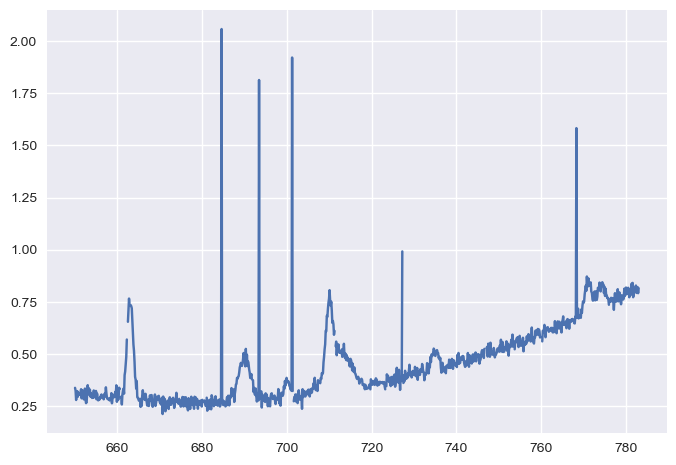

In [18]:
_ = plt.plot(df["Wavelength (nm)"], df["Intensity (arb. unit)"])